<p align = "center" draggable=”false” ><img src="https://github.com/AI-Maker-Space/LLM-Dev-101/assets/37101144/d1343317-fa2f-41e1-8af1-1dbb18399719" 
     width="200px"
     height="auto"/>
</p>

<h1 align="center" id="heading">RAG in Practice - 2025</h1>

In this event, we'll be looking at best-practice tools for RAG in 2025.

We'll go over how to build a solid baseline RAG application (essentially what is tablestakes as of March 26th, 2025). 

This is by no means the *end* of the line for RAG - but it is what you should be building *at minimum* as you create RAG applications. 

Let's start with a big ole wall of environment variables.

> NOTE: We're using cloud endpoints for demonstration purposes, you could deploy these models locally to avoid transmitting data outside your org. if required. There is one exception, with Cohere's Rerank model - an open-source alternative will be provided in the section for Reranking.

In [1]:
import os 
import getpass

os.environ["TOGETHER_API_KEY"] = getpass.getpass("Provide your Together API Key: ")
os.environ["COHERE_API_KEY"] = getpass.getpass("Provide your Cohere API Key: ")
os.environ["NVIDIA_API_KEY"] = getpass.getpass("Provide your NVIDIA API Key: ")

We'll also select a best practice visibility and monitoring tool LangSmith, assuming you are using the LangX ecosystem for building the RAG application. 

> NOTE: You should substitute this tool with [Arize Phoenix](https://docs.arize.com/phoenix) if you are not using the LangX ecosystem.

In [2]:
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "RAG-In-Practice-2025"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Provide your Langsmith API Key: ")

## Ingestion of Documents

Notice how we're not using LangChain's default splitters. While this example is simplified - the idea holds true: 

Chunking/splitting is something that should be done in a thought-out way, relying on base chunking strategies is not a suggested practice. 

Since our data is quotations separated by `\n\n` - we'll build a simple function that splits our data into coherent chunks.

In [3]:
def split_docs(doc_path: str) -> list:
    # Read the document
    with open(doc_path, 'r', encoding='utf-8') as file:
        content = file.read()
    
    # Split the document by double newlines
    chunks = content.split('\n\n')
    
    # Remove any empty chunks
    chunks = [chunk.strip() for chunk in chunks if chunk.strip()]
    
    return chunks

In [4]:
da_vinci_documents = split_docs("./data/da_vinci.txt")
len(da_vinci_documents)

89

In [5]:
da_vinci_documents[0]

'There are three classes of people: those who see. Those who see when they are shown. Those who do not see.'

In [6]:
henry_david_thoreau_documents = split_docs("./data/henry_david_thoreau.txt")
len(henry_david_thoreau_documents)

50

In [7]:
henry_david_thoreau_documents[0]

'1. “All good things are wild and free.”'

As you can see - our Thoreau quotations have distracting characters - we'll clean those. 

> NOTE: Data quality is still incredibly important - again, this is a simple example - but it's meant to demonstate that you should care about your data. 

In [8]:
import re

def clean_hdt_quotations(list_of_quotations):
    cleaned_quotations = []
    
    for quotation in list_of_quotations:
        without_numbering = re.sub(r'^\d+\.\s+', '', quotation)
        
        cleaned_quote = without_numbering.strip('”')
        if cleaned_quote.startswith('“'):
            cleaned_quote = cleaned_quote[1:]
        
        cleaned_quotations.append(cleaned_quote)
    
    return cleaned_quotations

In [15]:
henry_david_thoreau_documents_clean = clean_hdt_quotations(henry_david_thoreau_documents)
henry_david_thoreau_documents_clean[0]

'All good things are wild and free.'

## Embedding Model

We'll be using [llama-3.2-nv-embedqa-1b-v2](https://build.nvidia.com/nvidia/llama-3_2-nv-embedqa-1b-v2) as our Embedding Model today - it's fast, efficient, has long context, supports multiple languages, has incredibly high scores for retrieval tasks, and can be securely and locally hosted as a NIM. 

In [9]:
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings

nvidia_embeddings = NVIDIAEmbeddings(
  model="nvidia/llama-3.2-nv-embedqa-1b-v2", 
  truncate="NONE", 
)

In [10]:
len(nvidia_embeddings.embed_query("Hello, there!"))

2048

## Creating Vector Store - Qdrant

Qdrant is our recommended Vector Database as it serves as a tool that you can start with, and will scale with you as your needs grow. 

In [11]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

In [12]:
client.create_collection(
    collection_name="quote_collection",
    vectors_config=VectorParams(size=2048, distance=Distance.COSINE),
)

True

In [13]:
vector_store = QdrantVectorStore(
    client=client,
    collection_name="quote_collection",
    embedding=nvidia_embeddings,
)

> NOTE: Notice how we inject metadata into Qdrant - this can be leveraged directly or indirectly as we'll see when we use the application. 

In [16]:
from uuid import uuid4
from langchain_core.documents import Document

documents = []
uuids = []

for i, quote in enumerate(henry_david_thoreau_documents_clean):
    document = Document(
        page_content=quote,
        metadata={"author": f"Henry David Thoreau"},
    )
    uuid = str(uuid4())
    documents.append(document)
    uuids.append(uuid)

_ = vector_store.add_documents(documents=documents, ids=uuids)

In [17]:
documents = []
uuids = []

for i, quote in enumerate(da_vinci_documents):
    document = Document(
        page_content=quote,
        metadata={"author": f"Leonardo da Vinci"},
    )
    uuid = str(uuid4())
    documents.append(document)
    uuids.append(uuid)

_ = vector_store.add_documents(documents=documents, ids=uuids)

## Creating our Retriever

We are going to recommend that for retrieval you begin with: 

1. Hybrid Retrieval (Dense + Keyword)
2. Reranking 

While methods like HyDE can be leveraged to great effect in some situations (as was shown in [this paper](https://arxiv.org/pdf/2407.01219)) - they're not as universally useful as the above flow. 

### Hybrid Retrieval

We'll combine our dense retreival (LLM Embeddings) with BM25 and combine them with reciprocal rank-fusion (rRF) to produce a final list. 

> NOTE: We are choosing 5 pieces of context from both retrieval processes - this is an adjustable hyperparameter. The number should be larger than your final desired number of documents since the Reranking process can be used to filter out the lowest scoring options.

In [18]:
from langchain.retrievers import EnsembleRetriever
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_texts(
    texts=henry_david_thoreau_documents_clean+da_vinci_documents,
)
bm25_retriever.k = 5

hybrid_retriever = EnsembleRetriever(
    retrievers=[
        vector_store.as_retriever(search_kwargs={"k": 5}), 
        bm25_retriever
    ],
    weights=[0.5, 0.5],
)

### Reranking

Reranking is an extremely important piece of the puzzle - as it allows us to more deeply search through a subset of our documents. 

> NOTE: As an open-source alternative, you could use [llama-3.2-nv-rerankqa-1b-v2](https://build.nvidia.com/nvidia/llama-3_2-nv-rerankqa-1b-v2), which has the same benefits as the Embedding Model.

In [19]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

cohere_rerank = CohereRerank(
    model="rerank-english-v3.0",
    top_n=5,
)

reranker = ContextualCompressionRetriever(
    base_compressor=cohere_rerank, base_retriever=hybrid_retriever
)

## RAG Prompt

Prompts are still crucial - and while this prompt works well for this use-case, time should still be spent on exactly how you're prompting your LLM based on a number of factors. (generator model being used, number of documents retrieved, etc.)

This process is, like data ingestion, something to spend time and effort on. 

In [20]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """
#CONTEXT:
{context}

QUERY:
{query}

Use the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it's not contained in the provided context response with "I don't know"
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("human", RAG_TEMPLATE)
])

## Generator

While we're recommending [meta-llama/Llama-3.3-70B-Instruct](https://huggingface.co/meta-llama/Llama-3.3-70B-Instruct) as the "default best RAG model" - this is another choice that is use-case, domain, and cost based. 

Right-sizing your model is still a difficult process in 2025 - but for most use-cases where you need a good model and can afford/support Llama 3.3 70B Instruct - you should find it extremely effective. 

In [21]:
from langchain_together import ChatTogether

llm = ChatTogether(
    model="meta-llama/Llama-3.3-70B-Instruct-Turbo",
    temperature=0.0,
)

In [22]:
llm.invoke("What did Thoreau say about the importance of solitude?")

AIMessage(content='Henry David Thoreau, an American philosopher and writer, emphasized the importance of solitude in his works, particularly in his book "Walden; or, Life in the Woods" (1854). He believed that solitude was essential for personal growth, self-reflection, and a deeper connection with nature.\n\nThoreau argued that solitude allowed individuals to escape the distractions and superficialities of everyday life, and to focus on their inner lives and spiritual development. He wrote, "I never found a companion that was so companionable as solitude" (Walden, Chapter 5).\n\nThoreau\'s experience of living alone in a cabin near Walden Pond for two years (1845-1847) was a deliberate experiment in simplicity and solitude. He sought to simplify his life, live in harmony with nature, and cultivate a sense of inner peace and contentment.\n\nIn "Walden," Thoreau noted that solitude allowed him to:\n\n1. **Reflect on his life and values**: Solitude gave him the opportunity to examine his

## Creating RAG Graph

We continue to suggest people to use LangGraph in 2025. Notice that LCEL is largely removed as the core way to interact with the LangX ecosystem - as we prefer to interact with it through LangGraph. 

In [23]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class RAGState(TypedDict):
  question: str
  context: List[Document]
  response: str

> NOTE: There is a subtle best-practice in the next cell, which is to return your contexts in ascending order. 

In [24]:
def retrieve(state: RAGState) -> RAGState:
  retrieved_docs = reranker.invoke(state["question"])
  return {"context" : retrieved_docs[::-1]}

In [25]:
from langchain_core.output_parsers import StrOutputParser

def generate(state: RAGState) -> RAGState:
  generation_chain = chat_prompt | llm | StrOutputParser()
  response = generation_chain.invoke({"query" : state["question"], "context" : state["context"]})
  return {"response" : response}

In [26]:
graph_builder = StateGraph(RAGState)
graph_builder = graph_builder.add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

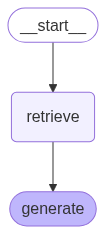

In [27]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Testing our Pipeline

### Not Present in Documents

In this case, we know the question should not be answerable.

In [28]:
response = graph.invoke({"question" : "Why do birds sing?"})
response["response"]

"I don't know"

### Wrong Author

In this case, we know Da Vinci didn't have quotes about solitude in the corpus we used - but Thoreau did. 

In [29]:
response = graph.invoke({"question" : "What did Da Vinci have to say about solitude?"})
response["response"]

"I don't know"

In [30]:
response["context"]

[Document(metadata={'relevance_score': 1.3109144e-05}, page_content='Life isn’t about finding yourself; it’s about creating yourself. So live the life you imagined.'),
 Document(metadata={'author': 'Leonardo da Vinci', '_id': 'cc757a23-7778-4901-bed1-c2961217f005', '_collection_name': 'quote_collection', 'relevance_score': 1.7778551e-05}, page_content="Now you see that the hope and the desire of returning home and to one's former state is like the moth to the light, and that the man who with constant longing awaits with joy each new spring time, each new summer, each new month and new year — deeming that the things he longs for are ever too late in coming — does not perceive that he is longing for his own destruction. But this desire is the very quintessence, the spirit of the elements, which finding itself imprisoned with the soul is ever longing to return from the human body to its giver. And you must know that this same longing is that quintessence, inseparable from nature, and that

### Present in Documents

Of course, the system should work for cases where the documentation exists. 

In [31]:
response = graph.invoke({"question" : "What did Thoreau have to say about solitude?"})
response["response"]

'According to the provided context, Henry David Thoreau said: "I find it wholesome to be alone the greater part of the time. To be in company, even with the best, is soon wearisome and dissipating. I love to be alone. I never found the companion that was so companionable as solitude."'

In [32]:
response["context"]

[Document(metadata={'relevance_score': 4.5397872e-05}, page_content='Life isn’t about finding yourself; it’s about creating yourself. So live the life you imagined.'),
 Document(metadata={'author': 'Leonardo da Vinci', '_id': '4c7e060f-b999-469a-8609-6ad5810c8aa3', '_collection_name': 'quote_collection', 'relevance_score': 0.00021152888}, page_content='If you meet with any one who is virtuous do not drive him from you; do him honour, so that he may not have to flee from you and be reduced to hiding in hermitages, or caves or other solitary places to escape from your treachery; if there is such an one among you do him honour, for these are our Saints upon earth; these are they who deserve statues from us, and images...'),
 Document(metadata={'author': 'Leonardo da Vinci', '_id': 'd2c6e603-f7e5-43a8-a200-4ee0ab3fe9fc', '_collection_name': 'quote_collection', 'relevance_score': 0.0007321813}, page_content='"Study me, reader, if you delight in me, because on very few occasions shall I retu

### Synthesizing Responses

Asking about quotes that are similar should allow us to compare and contrast each author's thoughts. 

In [33]:
response = graph.invoke({"question" : "What did Da Vinci and Thoreau say about perception/seeing? Compare and contrast their thoughts."})
response["response"]

'Based on the provided context, here\'s a comparison of Da Vinci and Thoreau\'s thoughts on perception/seeing:\n\nDa Vinci\'s quotes suggest that he believed perception and seeing are closely tied to the functioning of the eye and the study of nature. He stated that "Drawing is based upon perspective, which is nothing else than a thorough knowledge of the function of the eye" and "All our knowledge has its origin in our perceptions." He also wondered about the difference in clarity between dreams and wakefulness, asking "Why does the eye see a thing more clearly in dreams than the imagination when awake?"\n\nThoreau, on the other hand, emphasized the importance of what one sees, rather than just what one looks at. He said, "It\'s not what you look at that matters, it\'s what you see."\n\nIn contrast to Da Vinci\'s focus on the physical aspect of seeing (the eye), Thoreau\'s quote suggests a more introspective and interpretive approach to perception. While Da Vinci seems to be concerned

## Evalution

For Evaluating RAG applications in 2025 - we continue to recommend [Ragas](https://github.com/explodinggradients/ragas/tree/main) as a best practice tool. 

> NOTE: Please see our [Ragas event](https://www.youtube.com/watch?v=bB56BaQIBm4) for more in-depth explanations and examples!

In [34]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("Provide your OpenAI API Key:")

In [35]:
from ragas import SingleTurnSample
from ragas.metrics import AspectCritic
from ragas.llms import LangchainLLMWrapper
from langchain_openai import ChatOpenAI

test_data = {
    "user_input": "What did Da Vinci and Thoreau say about perception/seeing? Compare and contrast their thoughts.",
    "response": response["response"],
}
evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
metric = AspectCritic(name="fully_answered",llm=evaluator_llm, definition="Verify if the question was answered completely.")
await metric.single_turn_ascore(SingleTurnSample(**test_data))

1